In [2]:
# Required columns on input dataframe: 
#['timestamp', 'series_id', 'Brand', 'Resource ID', 'ADD', 'sin_week', 'cos_week', 'week_number']


# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from modules.features import load_data, series_exog, train_test_split, calculate_stats_train, normalize_series, create_time_series_dicts, get_split_col, get_df_input, get_full_data, get_future_exog

from modules.plotting import plot_series, plot_train_test_split, plot_results, plot_results_dual_scale

from modules.lgbm_architecture import create_forecaster, tune_forecaster, create_final_forecaster, backtest_forecaster, fit_predict

from modules.metrics import format_results, residuals, get_full_metrics

c:\Users\maria.diazalba\OneDrive - Cordis US Corp\0 MARIA\SKU Demand\venv_psr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
filepath="./features_py.xlsx"

features = load_data(filepath)

series_ini, exog_ini = series_exog(features)

df_full = get_split_col(series_ini)

df_full

,timestamp,Brand,Resource ID,split,series_id
0,2024-07-03,ADROIT,E00A,0.066996,ADROIT||E00A
1,2024-07-03,ADROIT,E00B,0.933004,ADROIT||E00B
2,2024-07-03,ANGIOGUARD,EM_L81,1.000000,ANGIOGUARD||EM_L81
3,2024-07-03,AQUATRACK,EM_L71,1.000000,AQUATRACK||EM_L71
4,2024-07-03,ARC ROYAL,EM_O01_NL,0.221582,ARC ROYAL||EM_O01_NL
...,...,...,...,...,...
7918,2025-07-30,VISTA BRITE TIP (MODIFIED),A01,0.000000,VISTA BRITE TIP (MODIFIED)||A01
7919,2025-07-30,VISTA BRITE TIP (MODIFIED),E00D,1.000000,VISTA BRITE TIP (MODIFIED)||E00D
7920,2025-07-30,WIZDOM,EM_K60,1.000000,WIZDOM||EM_K60
7921,2025-07-30,WIZDOM,EM_K60_NL,0.000000,WIZDOM||EM_K60_NL


In [6]:
df_input = get_df_input(df_full)

wk_feats = (exog_ini[['timestamp', 'sin_week', 'cos_week', 'week_number']]
            .drop_duplicates(subset=['timestamp']))
df_input = df_input.merge(wk_feats, on='timestamp', how='left')

series, exog = series_exog(df_input)

series

,timestamp,series_id,split,s_split
0,2024-07-03,ADROIT||E00A,0.066996,-2.633772
1,2024-07-03,ADROIT||E00B,0.933004,2.633772
2,2024-07-03,ANGIOGUARD||EM_L81,1.000000,13.815510
3,2024-07-03,AQUATRACK||EM_L71,1.000000,13.815510
4,2024-07-03,ARC ROYAL||EM_O01_NL,0.221582,-1.256471
...,...,...,...,...
7918,2025-07-30,VISTA BRITE TIP (MODIFIED)||A01,0.000000,-13.815510
7919,2025-07-30,VISTA BRITE TIP (MODIFIED)||E00D,1.000000,13.815510
7920,2025-07-30,WIZDOM||EM_K60,1.000000,13.815510
7921,2025-07-30,WIZDOM||EM_K60_NL,0.000000,-13.815510


In [51]:
series_train, series_test, exog_train, exog_test = train_test_split(series, exog)

series_dict_train, series_dict_test, exog_dict_train, exog_dict_test = create_time_series_dicts(
    series_train, series_test, exog_train, exog_test, target_col='s_split'
)

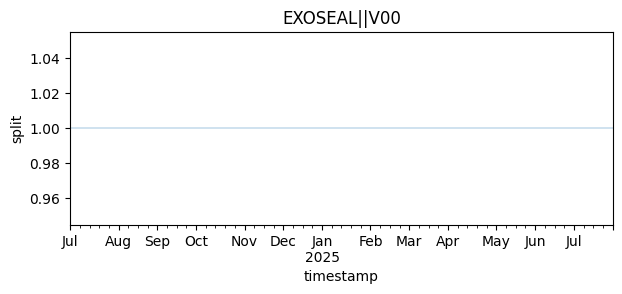

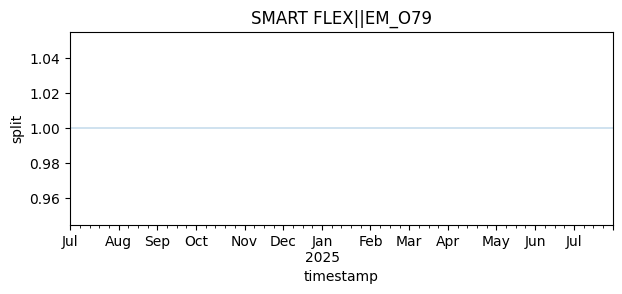

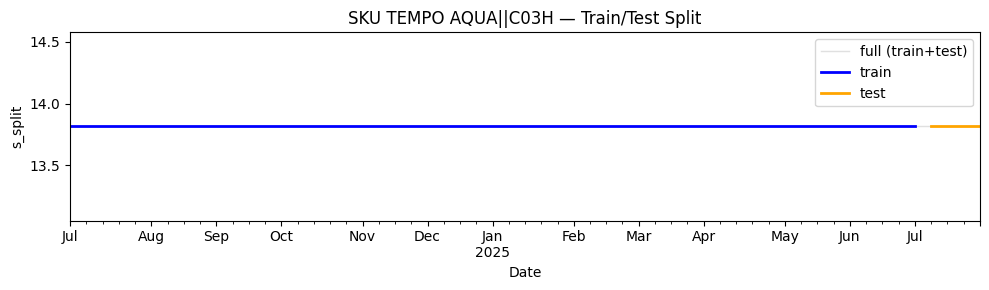

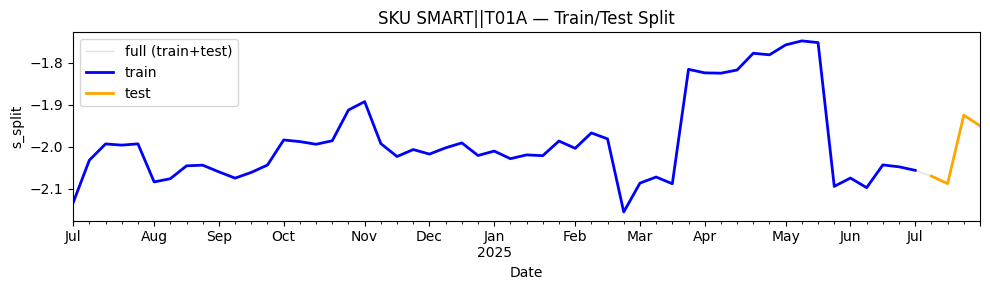

In [52]:
plot_series(df_input, column='split')
plot_train_test_split(series_dict_train, series_dict_test, ylabel='s_split')

In [53]:
forecaster = create_forecaster()
forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: None 
Window size: 4 
Series encoding: ordinal 
Series names (levels): None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8,
    'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 600, 'n_jobs': -1, 'num_leaves': 63, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8,
    'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2025-10-27 16:05:05 
Last fit date: None 
Skforecast version: 0.17.0 
Python version: 3.13.5 
Forecaster id: None

In [54]:
# best_params, best_lags = tune_forecaster(series_dict_train, exog_dict_train)

In [55]:
## MANUAL SELECTION FOR FASTER RUNNING (TEMPORAL)
best_lags= [1, 2, 3, 4]
#best_params= {'n_estimators': 300, 'max_depth': 6, 'num_leaves': 47, 'min_child_samples': 90, 'learning_rate': 0.056600578449100186, 'feature_fraction': 0.7, 'bagging_fraction': 0.8, 'lambda_l1': 0.7000000000000001, 'lambda_l2': 0.30000000000000004}

best_params = {'n_estimators': 200, 'max_depth': 5, 'num_leaves': 47, 'min_child_samples': 90, 'learning_rate': 0.06107135917674153, 'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'lambda_l1': 0.7000000000000001, 'lambda_l2': 0.30000000000000004}


In [56]:
final_forecaster = create_final_forecaster(best_params, best_lags)
final_forecaster

============================== 
ForecasterRecursiveMultiSeries 
============================== 
Regressor: LGBMRegressor 
Lags: [1 2 3 4] 
Window features: ['roll_mean_4', 'roll_mean_7'] 
Window size: 7 
Series encoding: ordinal 
Series names (levels): None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Weight function included: False 
Series weights: None 
Differentiation order: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.06107135917674153,
    'max_depth': 5, 'min_child_samples': 90, 'min_child_weight': 0.001,
    'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves':
    47, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda':
    0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0,
    'feature_fraction': 0.7, 'bagging_fraction': 1.0, 'lambda_l1':
    0.7000000000000001, 'lambda_l2': 0.30000000000000004} 
fit_kwargs: {} 
Creation date: 2025-10-27 16:05:06 
Last fit date: None 
Skforecast version: 0.17.0 
Python version: 3.13.5 
Forecaster id: None

In [57]:
metrics_levels, backtest_predictions = backtest_forecaster(final_forecaster, series_dict_train, exog_dict_train)

Backtesting setup:
- Steps: 4
- Folds: 3
- Validation weeks: 12
- Initial train size: 41
Information of folds
--------------------
Number of observations used for initial training: 41
Number of observations used for backtesting: 12
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 4
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2024-07-03 00:00:00 -- 2025-04-09 00:00:00  (n=41)
    Validation: 2025-04-16 00:00:00 -- 2025-05-07 00:00:00  (n=4)
Fold: 1
    Training:   2024-07-31 00:00:00 -- 2025-05-07 00:00:00  (n=41)
    Validation: 2025-05-14 00:00:00 -- 2025-06-04 00:00:00  (n=4)
Fold: 2
    Training:   2024-08-28 00:00:00 -- 2025-06-04 00:00:00  (n=41)
    Validation: 2025-06-11 00:00:00 -- 2025-07-02 00:00:00  (n=4)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=

  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: b

 67%|██████▋   | 2/3 [00:00<00:00,  4.54it/s]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: b

100%|██████████| 3/3 [00:00<00:00,  3.61it/s]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: b


Backtesting Results:
                series_id  mean_absolute_error
0            ADROIT||E00A             0.324415
1            ADROIT||E00B             0.371415
2      ANGIOGUARD||EM_L81             0.031522
3       AQUATRACK||EM_L71             0.031059
4    ARC ROYAL||EM_O01_NL             0.163413
..                    ...                  ...
137     WIZDOM||EM_K60_NL             0.061286
138        ZEPHYR||EM_O89             0.013022
139               average             0.102719
140      weighted_average             0.102719
141               pooling             0.102719

[142 rows x 2 columns]

Predictions Sample:
                       series_id       pred
2025-04-16          ADROIT||E00A  -3.558247
2025-04-16          ADROIT||E00B   3.708275
2025-04-16    ANGIOGUARD||EM_L81  13.803067
2025-04-16     AQUATRACK||EM_L71  13.803067
2025-04-16  ARC ROYAL||EM_O01_NL  -2.400670


- y_s = split_s
- y = split

In [58]:
f_backtest_predictions = format_results(backtest_predictions, 
                                        series_dict_train,
                                        df_full,
                                        'v2')
f_backtest_predictions

(      timestamp              series_id     pred_s        y_s  abs_error_s  \
 0    2025-04-16           ADROIT||E00A  -3.558247  -3.579768     0.021521   
 1    2025-04-16           ADROIT||E00B   3.708275   3.579768     0.128507   
 2    2025-04-16     ANGIOGUARD||EM_L81  13.803067  13.815510     0.012442   
 3    2025-04-16      AQUATRACK||EM_L71  13.803067  13.815510     0.012442   
 4    2025-04-16   ARC ROYAL||EM_O01_NL  -2.400670  -1.960673     0.439998   
 ...         ...                    ...        ...        ...          ...   
 1663 2025-07-02  VISTA BRITE TIP||E02B  -2.300040  -2.145316     0.154724   
 1664 2025-07-02  VISTA BRITE TIP||E02C  -2.917731  -3.147611     0.229880   
 1665 2025-07-02         WIZDOM||EM_K60  13.815272  13.815510     0.000238   
 1666 2025-07-02      WIZDOM||EM_K60_NL -13.844884 -13.815510     0.029374   
 1667 2025-07-02         ZEPHYR||EM_O89  13.815272  13.815510     0.000238   
 
          mae_s          pred         y     abs_error       ma

In [59]:
plot_results(predictions_df=f_backtest_predictions, 
             n_val_weeks = 12, 
             real_serie=series_train,
             n_plots=2, 
             specific_series='TEMPO||C03F',
             col='split')

Serie: TEMPO||C03F


AttributeError: 'tuple' object has no attribute 'loc'

In [60]:
predictions = fit_predict(final_forecaster, series_dict_train, series_dict_test, exog_dict_train= exog_dict_train, exog_dict_test=exog_dict_test)
predictions

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.7000000000000001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7000000000000001
[LightGBM] [Warning] lambda_l2 is set=0.30000000000000004, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: b

,series_id,pred
2025-07-09,ADROIT||E00A,-5.394114
2025-07-09,ADROIT||E00B,4.871144
2025-07-09,ANGIOGUARD||EM_L81,13.807194
2025-07-09,AQUATRACK||EM_L71,13.807194
2025-07-09,ARC ROYAL||EM_O01_NL,-2.291398
...,...,...
2025-07-30,VISTA BRITE TIP||E02B,-2.144503
2025-07-30,VISTA BRITE TIP||E02C,-3.150077
2025-07-30,WIZDOM||EM_K60,13.793428
2025-07-30,WIZDOM||EM_K60_NL,-13.931398


In [61]:
f_predictions, scale_mae_global, mae_global = format_results(predictions,
                               series_dict_test,
                               df_full,
                               'v2')
f_predictions

,timestamp,series_id,pred_s,y_s,abs_error_s,mae_s,pred,y,abs_error,mae
0,2025-07-09,ADROIT||E00A,-5.394114,-5.391944,0.002170,0.077510,4.536685e-03,0.004532,4.210646e-06,3.389837e-04
1,2025-07-09,ADROIT||E00B,4.871144,5.391944,0.520800,0.644936,9.954633e-01,0.995468,4.210646e-06,3.389837e-04
2,2025-07-09,ANGIOGUARD||EM_L81,13.807194,13.815510,0.008315,0.007439,1.000000e+00,1.000000,0.000000e+00,0.000000e+00
3,2025-07-09,AQUATRACK||EM_L71,13.807194,13.815510,0.008315,0.007439,1.000000e+00,1.000000,0.000000e+00,0.000000e+00
4,2025-07-09,ARC ROYAL||EM_O01_NL,-2.291398,-2.183981,0.107417,0.132255,9.318477e-02,0.101198,8.013441e-03,1.097602e-02
...,...,...,...,...,...,...,...,...,...,...
551,2025-07-30,VISTA BRITE TIP||E02B,-2.144503,-2.219082,0.074579,0.043762,1.047101e-01,0.098050,6.660139e-03,3.900462e-03
552,2025-07-30,VISTA BRITE TIP||E02C,-3.150077,-3.048787,0.101290,0.110272,4.103498e-02,0.045270,4.234875e-03,4.607515e-03
553,2025-07-30,WIZDOM||EM_K60,13.793428,13.815510,0.022082,0.022708,9.999991e-01,1.000000,8.905750e-07,8.905750e-07
554,2025-07-30,WIZDOM||EM_K60_NL,-13.931398,-13.815510,0.115888,0.115888,8.905750e-07,0.000000,8.905750e-07,8.905750e-07


In [62]:
scale_mae_global

np.float64(0.20102870078656582)

In [63]:
mae_global

np.float64(0.0049349482006438026)

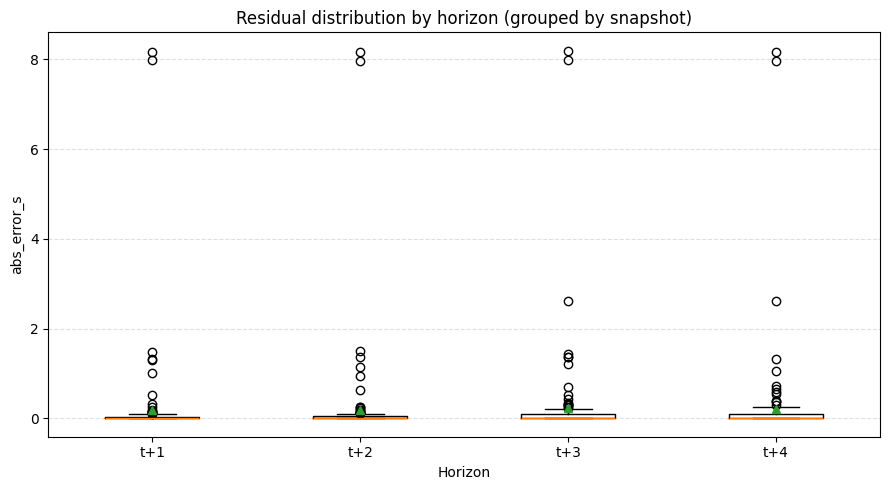

           n      mean    median       std
horizon                                   
t+1      139  0.181505  0.002883  0.982139
t+2      139  0.183650  0.002382  0.980152
t+3      139  0.224906  0.003004  1.007201
t+4      139  0.214053  0.003004  0.994234


In [64]:
residuals(f_predictions, error_col='abs_error_s')

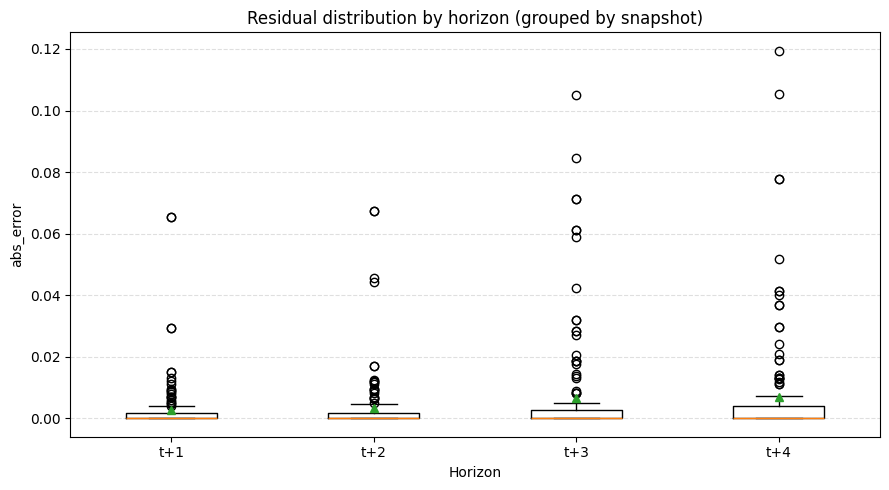

           n      mean  median       std
horizon                                 
t+1      139  0.002857     0.0  0.008882
t+2      139  0.003232     0.0  0.009948
t+3      139  0.006679     0.0  0.017468
t+4      139  0.006971     0.0  0.018363


In [65]:
residuals(f_predictions, error_col='abs_error')


Serie: PALMAZ UNMOUNTED||EM_U90
       y  pred  abs_error
68   1.0   1.0        0.0
207  1.0   1.0        0.0
346  1.0   1.0        0.0
485  1.0   1.0        0.0
MAE 0.000000


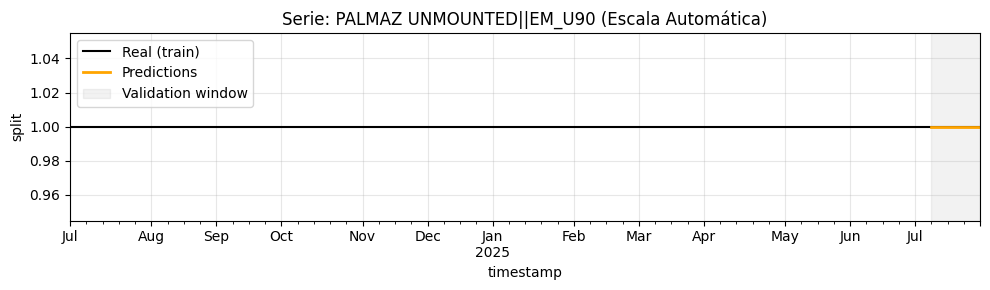

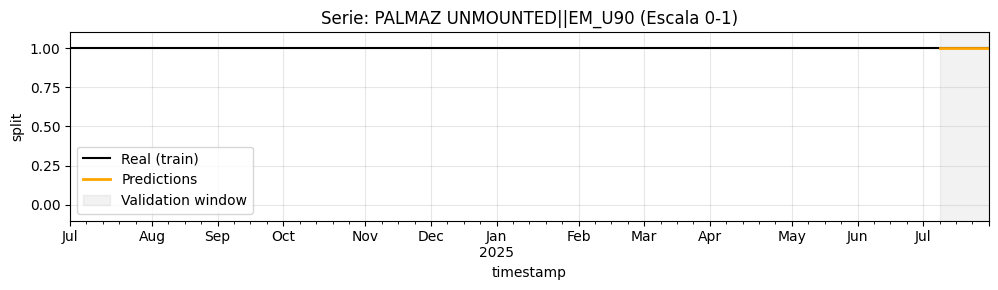


Serie: ATW WIRE||EM_L51_NL
            y      pred  abs_error
10   0.000406  0.000149   0.000258
149  0.000381  0.000148   0.000233
288  0.000501  0.000148   0.000353
427  0.000432  0.000151   0.000281
MAE 0.000281


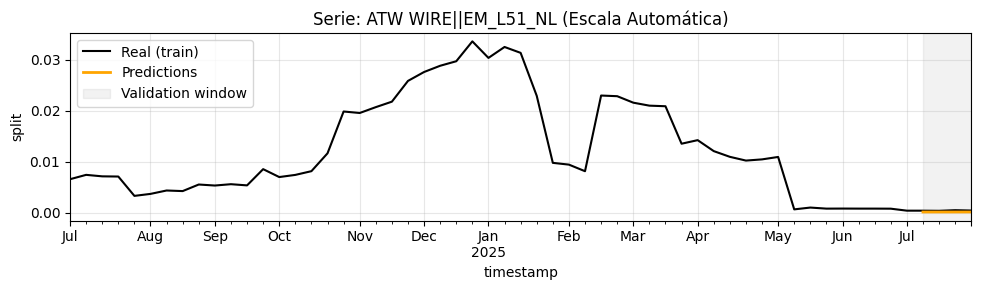

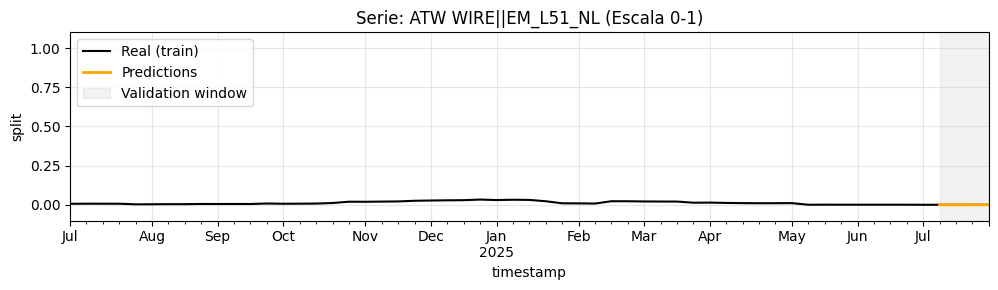


Serie: PRIMOPAC||C04B
       y  pred  abs_error
75   1.0   1.0        0.0
214  1.0   1.0        0.0
353  1.0   1.0        0.0
492  1.0   1.0        0.0
MAE 0.000000


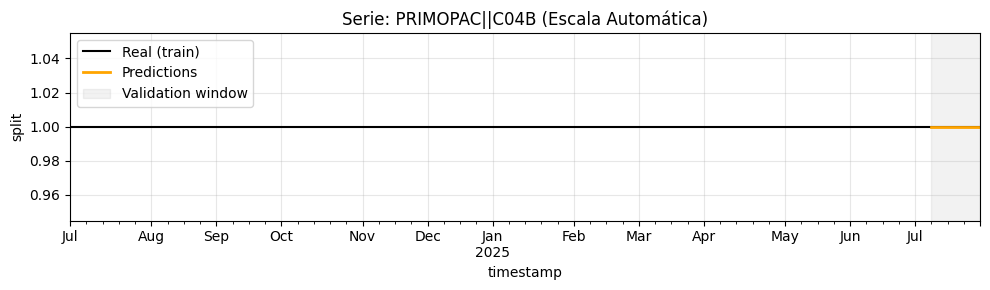

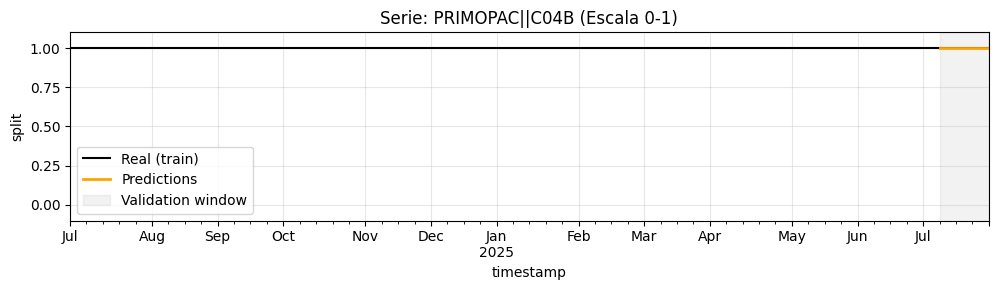


Serie: PROPAC (MODIFIED)||C04B
       y  pred  abs_error
76   1.0   1.0        0.0
215  1.0   1.0        0.0
354  1.0   1.0        0.0
493  1.0   1.0        0.0
MAE 0.000000


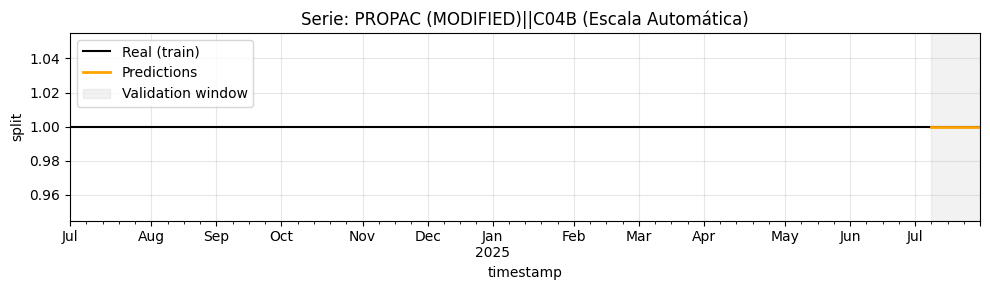

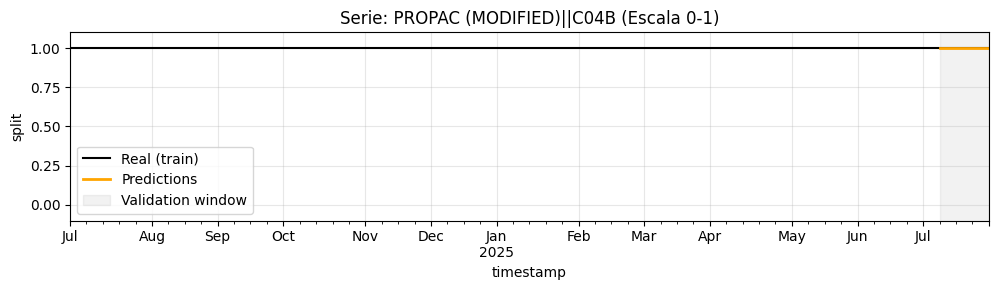


Serie: VASSALLO GT EXT GW||EM_O90
       y  pred  abs_error
124  1.0   1.0        0.0
263  1.0   1.0        0.0
402  1.0   1.0        0.0
541  1.0   1.0        0.0
MAE 0.000000


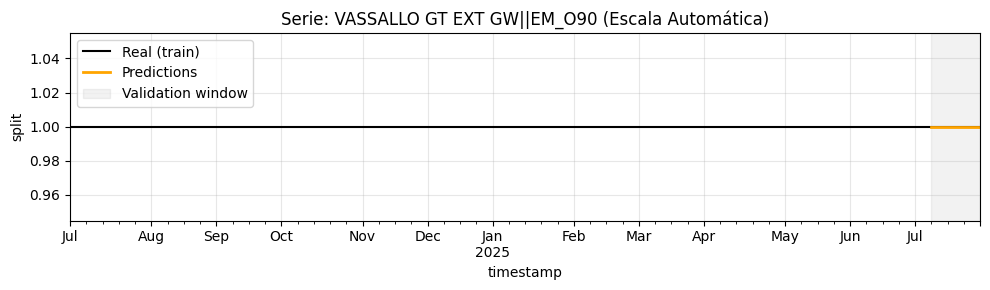

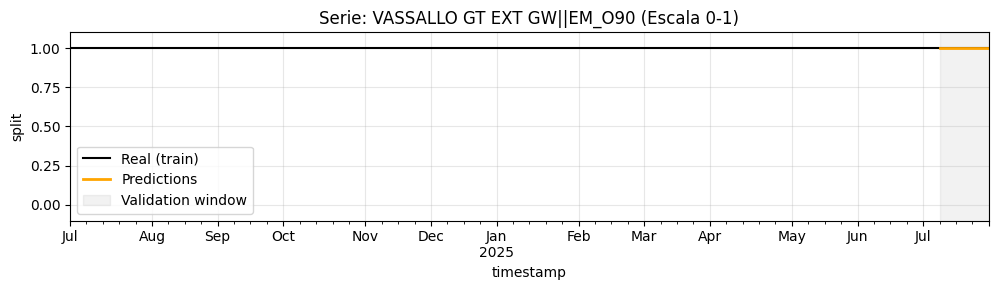

In [66]:
all_skus = series["series_id"].unique().tolist()

plot_results_dual_scale(predictions_df=f_predictions, 
             n_val_weeks = 4, 
             real_serie=series,
             n_plots=5,
             #specific_series=all_skus,
             col='split')


In [67]:
horizon = 8

series_full_dict, exog_full_dict = get_full_data(series, 
                                         exog, 
                                         'split')            
forecaster.fit(series=series_full_dict,
               exog=exog_full_dict)

future_exog_dict = get_future_exog(horizon, series)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1296
[LightGBM] [Info] Number of data points in the train set: 7367, number of used features: 8
[LightGBM] [Info] Start training from score 0.712230


In [68]:
predictions = forecaster.predict(steps=horizon, exog=future_exog_dict)
predictions

,level,pred
2025-08-06,ADROIT||E00A,0.002869
2025-08-06,ADROIT||E00B,0.995182
2025-08-06,ANGIOGUARD||EM_L81,1.000203
2025-08-06,AQUATRACK||EM_L71,1.000309
2025-08-06,ARC ROYAL||EM_O01_NL,0.076392
...,...,...
2025-09-24,VISTA BRITE TIP||E02B,0.097029
2025-09-24,VISTA BRITE TIP||E02C,0.039353
2025-09-24,WIZDOM||EM_K60,0.998190
2025-09-24,WIZDOM||EM_K60_NL,0.005368


In [69]:
predictions = predictions.rename(columns={"level": 'series_id'})
predictions_for = predictions.copy()
predictions_for.index = pd.to_datetime(predictions_for.index)
predictions_for.index.name = "timestamp"
predictions_for = predictions_for.reset_index()


In [70]:
predictions_for

,timestamp,series_id,pred
0,2025-08-06,ADROIT||E00A,0.002869
1,2025-08-06,ADROIT||E00B,0.995182
2,2025-08-06,ANGIOGUARD||EM_L81,1.000203
3,2025-08-06,AQUATRACK||EM_L71,1.000309
4,2025-08-06,ARC ROYAL||EM_O01_NL,0.076392
...,...,...,...
1107,2025-09-24,VISTA BRITE TIP||E02B,0.097029
1108,2025-09-24,VISTA BRITE TIP||E02C,0.039353
1109,2025-09-24,WIZDOM||EM_K60,0.998190
1110,2025-09-24,WIZDOM||EM_K60_NL,0.005368


In [71]:
predictions_for[['Brand', 'Resource ID']] = predictions_for['series_id'].str.split(r'\|\|', expand=True)

In [72]:
predictions_for

,timestamp,series_id,pred,Brand,Resource ID
0,2025-08-06,ADROIT||E00A,0.002869,ADROIT,E00A
1,2025-08-06,ADROIT||E00B,0.995182,ADROIT,E00B
2,2025-08-06,ANGIOGUARD||EM_L81,1.000203,ANGIOGUARD,EM_L81
3,2025-08-06,AQUATRACK||EM_L71,1.000309,AQUATRACK,EM_L71
4,2025-08-06,ARC ROYAL||EM_O01_NL,0.076392,ARC ROYAL,EM_O01_NL
...,...,...,...,...,...
1107,2025-09-24,VISTA BRITE TIP||E02B,0.097029,VISTA BRITE TIP,E02B
1108,2025-09-24,VISTA BRITE TIP||E02C,0.039353,VISTA BRITE TIP,E02C
1109,2025-09-24,WIZDOM||EM_K60,0.998190,WIZDOM,EM_K60
1110,2025-09-24,WIZDOM||EM_K60_NL,0.005368,WIZDOM,EM_K60_NL


In [73]:
pred_col = predictions_for.pop('pred')     # Extrae la columna
predictions_for['pred'] = pred_col
predictions_for     

,timestamp,series_id,Brand,Resource ID,pred
0,2025-08-06,ADROIT||E00A,ADROIT,E00A,0.002869
1,2025-08-06,ADROIT||E00B,ADROIT,E00B,0.995182
2,2025-08-06,ANGIOGUARD||EM_L81,ANGIOGUARD,EM_L81,1.000203
3,2025-08-06,AQUATRACK||EM_L71,AQUATRACK,EM_L71,1.000309
4,2025-08-06,ARC ROYAL||EM_O01_NL,ARC ROYAL,EM_O01_NL,0.076392
...,...,...,...,...,...
1107,2025-09-24,VISTA BRITE TIP||E02B,VISTA BRITE TIP,E02B,0.097029
1108,2025-09-24,VISTA BRITE TIP||E02C,VISTA BRITE TIP,E02C,0.039353
1109,2025-09-24,WIZDOM||EM_K60,WIZDOM,EM_K60,0.998190
1110,2025-09-24,WIZDOM||EM_K60_NL,WIZDOM,EM_K60_NL,0.005368


In [74]:
features_54 = series[series['timestamp'] <= '2025-07-09']
features_54

,timestamp,series_id,split,s_split
0,2024-07-03,ADROIT||E00A,0.066996,-2.633772
1,2024-07-03,ADROIT||E00B,0.933004,2.633772
2,2024-07-03,ANGIOGUARD||EM_L81,1.000000,13.815510
3,2024-07-03,AQUATRACK||EM_L71,1.000000,13.815510
4,2024-07-03,ARC ROYAL||EM_O01_NL,0.221582,-1.256471
...,...,...,...,...
7501,2025-07-09,VISTA BRITE TIP (MODIFIED)||A01,0.000000,-13.815510
7502,2025-07-09,VISTA BRITE TIP (MODIFIED)||E00D,1.000000,13.815510
7503,2025-07-09,WIZDOM||EM_K60,1.000000,13.815510
7504,2025-07-09,WIZDOM||EM_K60_NL,0.000000,-13.815510


In [75]:
today='2025-07-09'
historical = features_54[features_54['series_id'] == 'ADROIT||E00A'].copy()
historical = historical.sort_values('timestamp')
historical['timestamp'] = pd.to_datetime(historical['timestamp'])
historical_until_today = historical[historical['timestamp'] <= today]
historical_until_today


,timestamp,series_id,split,s_split
0,2024-07-03,ADROIT||E00A,0.066996,-2.633772
139,2024-07-10,ADROIT||E00A,0.066950,-2.634505
278,2024-07-17,ADROIT||E00A,0.070636,-2.576954
417,2024-07-24,ADROIT||E00A,0.071039,-2.570834
556,2024-07-31,ADROIT||E00A,0.070927,-2.572543
695,2024-08-07,ADROIT||E00A,0.070728,-2.575553
834,2024-08-14,ADROIT||E00A,0.075725,-2.501904
973,2024-08-21,ADROIT||E00A,0.073191,-2.538681
1112,2024-08-28,ADROIT||E00A,0.071660,-2.561463
1251,2024-09-04,ADROIT||E00A,0.075032,-2.511847


In [95]:

test = pd.read_csv("./2025-10-27T21-15_export.csv")
test = test[['timestamp', 'series_id', 'pred']]
test

,timestamp,series_id,pred
0,2025-08-06T00:00:00.000,ADROIT||E00A,-5.601095
1,2025-08-06T00:00:00.000,ADROIT||E00B,5.293395
2,2025-08-06T00:00:00.000,ANGIOGUARD||EM_L81,13.693997
3,2025-08-06T00:00:00.000,AQUATRACK||EM_L71,13.693997
4,2025-08-06T00:00:00.000,ARC ROYAL||EM_O01_NL,-2.481862
...,...,...,...
551,2025-08-27T00:00:00.000,VISTA BRITE TIP||E02B,-2.237430
552,2025-08-27T00:00:00.000,VISTA BRITE TIP||E02C,-3.207927
553,2025-08-27T00:00:00.000,WIZDOM||EM_K60,13.785617
554,2025-08-27T00:00:00.000,WIZDOM||EM_K60_NL,-13.716488


In [102]:
predictions_for = test.copy()
predictions_for[['Brand', 'Resource ID']] = predictions_for['series_id'].str.split(r'\|\|', expand=True)

predictions_for['p_raw'] = 1.0 / (1.0 + np.exp(-predictions_for['pred'].astype(float)))
den = predictions_for.groupby(['timestamp', 'Brand'])['p_raw'].transform('sum')
predictions_for['pred'] = np.where(den > 0, predictions_for['p_raw'] / den, 0.0)
predictions_for

,timestamp,series_id,pred,Brand,Resource ID,p_raw
0,2025-08-06T00:00:00.000,ADROIT||E00A,0.003685,ADROIT,E00A,0.003680
1,2025-08-06T00:00:00.000,ADROIT||E00B,0.996315,ADROIT,E00B,0.995000
2,2025-08-06T00:00:00.000,ANGIOGUARD||EM_L81,1.000000,ANGIOGUARD,EM_L81,0.999999
3,2025-08-06T00:00:00.000,AQUATRACK||EM_L71,1.000000,AQUATRACK,EM_L71,0.999999
4,2025-08-06T00:00:00.000,ARC ROYAL||EM_O01_NL,0.078353,ARC ROYAL,EM_O01_NL,0.077140
...,...,...,...,...,...,...
551,2025-08-27T00:00:00.000,VISTA BRITE TIP||E02B,0.097623,VISTA BRITE TIP,E02B,0.096439
552,2025-08-27T00:00:00.000,VISTA BRITE TIP||E02C,0.039346,VISTA BRITE TIP,E02C,0.038869
553,2025-08-27T00:00:00.000,WIZDOM||EM_K60,0.999999,WIZDOM,EM_K60,0.999999
554,2025-08-27T00:00:00.000,WIZDOM||EM_K60_NL,0.000001,WIZDOM,EM_K60_NL,0.000001


In [92]:
0.0036850846409341243 + 0.9963149153590658

0.9999999999999999

In [104]:
5.51-2.12


3.3899999999999997